In [1]:
%reload_ext autoreload
%autoreload 3 -p

from bentPlumeAnalyser import gaussian_profile, show_scaled_image
from timeSeriesAnalysis.timeSeriesAnalysis import butter_lowpass_filtfilt

import pandas 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import json
import tifffile

# Set numpy options, notably for the printing of floating point numbers
np.set_printoptions(precision=6)

# Set matplotlib options
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['image.cmap'] = 'gray'

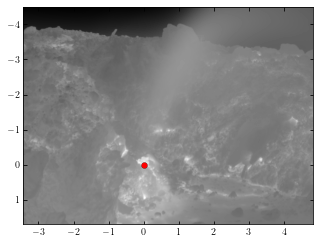

In [7]:
path  = '/home/david/FieldWork/Soufriere-Guadeloupe/Thermography/2018-03-05_CSN/'
fname = '20180305_CSN_imAve_bt.tif'

data  = tifffile.imread(path + fname)

vent_loc = (265.5194805194804, 348.07142857142856)
dist_to_vent = 8.44  # m, from logbook
wind_speed   = 1     # m/s
IFOV         = 1.53e-3  # rad - 15 mm IRBIS lens with FOV = 43.6
scale_factor = 1 / (2 * dist_to_vent * np.arctan(IFOV / 2))  # m / pixel
extent, im, ax = show_scaled_image(data, scale_factor, vent_loc)
ax.plot(0, 0, 'or')  # vent location

In [3]:
## DEFINE THE DISTANCE ALONG THE AXIS, THE ANGLE AND THE WIDTH OF THE PLUME
# sexp  = exptData.distAlongAxis
# thexp = exptData.plumeAngle
# bexp  = exptData.plumeWidth

path = './data/ExpPlumes_for_Dai/exp%02d/' % exptNo
with open(path + 'exp%02d_initGuess.json' % exptNo) as f:
    data = json.load(f)
p = np.array(data['data'])

data = np.flipud(loadmat(path + 'gsplume.mat')['gsplume'])
xexp = loadmat(path + 'xcenter.mat')['xcenter'][0]
zexp = loadmat(path + 'zcenter.mat')['zcenter'][0]
Ox, Oz = (xexp[0], zexp[0])
xexp = (xexp - Ox) / scaleFactor
zexp = (Oz - zexp) / scaleFactor

pPixels = p.copy() * scaleFactor
pPixels[:,0] += Ox
pPixels[:,1] -= Oz
pPixels[:,1] *= -1

# Calculate angle, width and distance along plume and errors
thexp, sig_thexp = plumeAngle(p[:,0], p[:,1], errors=[1/scaleFactor]*2)
_, bexp, sig_p, sig_bexp = trueLocationWidth(pPixels, data, errors=[1/scaleFactor])
sexp      = distAlongPath(p[:,0], p[:,1])
bexp     /= scaleFactor
sig_bexp /= scaleFactor
bexp[0]   = 0.55 / 2
thexp[0]  = np.pi / 2

NameError: name 'exptNo' is not defined

In [4]:
# Load initial conditions for a given experiment, run the model for those conditions 
# and then compare model and experimental data
pathname = '/home/david/Modelling/fumarolePlumeModel/data/'
V0, p = loadICsParameters(pathname, exptNo)
#%run fumarolePlumeModel.py
V0[0] *= 2.

# Initialise an integrator object
r = ode(derivs).set_integrator('lsoda', nsteps=1e6)
r.set_initial_value(V0, 0.)
r.set_f_params(p)
V = [V0]    # State vector
s = [0.]    # Axial distance

# Set integration domain and step size
t1 = 30.
dt = .1

# Integrate, whilst successful, until the domain size is reached
while r.successful() and r.t < t1:
    r.integrate(r.t + dt)
    V.append(r.y)
    s.append(r.t)

In [5]:
s = np.array(s)
V = np.array(V)
    
# Calculate the model predictions
# Extract the plume parameters from the state vector
q     = V[:,0]
m     = V[:,1]
f     = V[:,2]
theta = V[:,3]

# Calculate more intuitive plume parameters (width, speed and specific gravity)
b  = q / np.sqrt(m)
u  = m / q
gp = f / q

xmod, zmod = [0.], [0.]
ds_ = np.diff(s)
for (ds, th) in zip(ds_, theta):
    xmod.append(xmod[-1] + ds * np.cos(th))
    zmod.append(zmod[-1] + ds * np.sin(th))

In [6]:
# Directly compare the plume width and angle for experiment and model
# First, the model data has to be interpolated onto the same grid as the experimental data
from scipy.interpolate import interp1d
# Plume width
f = interp1d(s, b)
bmod = f(sexp)
# Plume angle
f = interp1d(s, theta)
thmod = f(sexp)

In [7]:
# Calculate an "objective function" which measures the misfit between data and model
# Initially, only use width and angle
Vexp = np.array([bexp, thexp]).T
Vmod = np.array([bmod, thmod]).T
sigV = np.array([sig_bexp, sig_thexp]).T

# The residual between experimental and model data
res = (Vexp - Vmod) / sigV
objFn = objectiveFn(Vexp.ravel(), Vmod.ravel(), np.diagflat(sigV.ravel())**2, p)

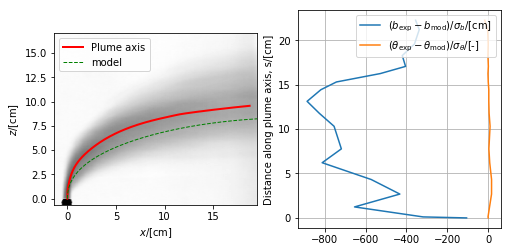

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# On an image of the experimental plume, show the plume trajectories for
# 1) GCTA, 2) our initial guess, 3) the model solution
data, xexp, zexp, extent = loadExptData(exptNo)
if data.mean() < .5:
    data = 1. - data
ax[0].imshow(data, extent=extent, cmap=plt.cm.gray)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$x$/[cm]')
ax[0].set_ylabel(r'$z$/[cm]')
# 1) GCTA
ax[0].plot(xexp, zexp, '-r', label='Plume axis', lw=2)
# 2) our initial guess
# ax[0].plot(exptData.axisLocn_x, exptData.axisLocn_y, 'r-', label='Init. guess', lw=2)
# 3) the model solution
ax[0].plot(xmod, zmod, '--g', label='model', lw=1)
ax[0].set_xlim((extent[:2]))
ax[0].legend(loc=2)

ax[1].plot(res[:,0], sexp, '-', label=r'$(b_{\mathrm{exp}} - b_{\mathrm{mod}})/\sigma_b$/[cm]')
ax[1].plot(res[:,1], sexp, '-', label=r'$(\theta_{\mathrm{exp}} - \theta_{\mathrm{mod}})/\sigma_{\theta}$/[-]')
ax[1].legend(loc=1, fancybox=True, framealpha=.8)
ax[1].grid()
ax[1].set_ylabel('Distance along plume axis, s/[cm]')

fig.savefig('plumeAnalyser_solution.png')

# ax[1].set_title('Objective fn: %.3f' % objFn)

(*Left*) Image of experimental plume with calculated and estimated trajectories.  (*Right*) Difference between experimental (guessed) and model solutions as a function of the distance along the plume axis.  

# To do:
- Make a grid of possible initial conditions and run the model for each case.  DONE
- Compare these solutions against the experimental data, computing an objective funtion for each case.  DONE
- Identify which cases produce minima in the objective function.  DONE
- Work in the downhill simplex (or other minimisation routine) to look for minima of the objective function.
- Plot the plume width along with axis track on averaged image.  

In [10]:
# Uncomment the following line to transform this notebook into a latex file
!jupyter nbconvert --to latex plumeAnalyser.ipynb

[NbConvertApp] Converting notebook plumeAnalyser.ipynb to latex
[NbConvertApp] Support files will be in plumeAnalyser_files/
[NbConvertApp] Making directory plumeAnalyser_files
[NbConvertApp] Writing 36000 bytes to plumeAnalyser.tex


In [11]:
# Now run pdflatex plumeAnalyser from the command line